# Federated learning - Client aggregation

### Imports

In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import copy
import random
import math
from sklearn.preprocessing import LabelBinarizer

In [2]:
## CONSTANTS
NUMBER_OF_CLIENTS = 10
MNIST_CLASS_AMOUNT = 10
MNIST_SHAPE = (28,28)
CIFAR_CLASS_AMOUNT = 10
LOCAL_EPOCHS = 1
ROUNDS = 100
LOCAL_LR = 0.01
GLOBAL_LR = 0.1
BATCH_SIZE = 32

optimizer = tf.keras.optimizers.SGD(LOCAL_LR, decay=LOCAL_LR/ROUNDS, momentum=0.9)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
model_metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]


## FT CONSTANTS
FT_EPOCHS = 3

### Utility

In [3]:
def sort_lists(list_a, list_b, data_entry, data_label):
    list_a[data_label].append(data_entry)
    list_b[data_label].append(data_label)
    
def sort_lists_cifar(list_a, list_b, data_entry, data_label):
    list_a[data_label[0]].append(data_entry)
    list_b[data_label[0]].append(data_label[0])
    
def split(array, partitions):
    k, m = divmod(len(array), partitions)
    return (array[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(partitions))

### Prepare the data

##### MNIST

In [4]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
ordered_train_data, ordered_train_data_labels, ordered_test_data, ordered_test_data_labels = [[[] for i in range(10)] for i in range(4)]
    
list(map(lambda a,b:sort_lists(ordered_train_data,ordered_train_data_labels, a, b), train_images, train_labels))
list(map(lambda a,b:sort_lists(ordered_test_data,ordered_test_data_labels, a, b), test_images, test_labels))
t = [4, 1, 4, 1, 3, 2, 2, 3, 4, 3]
#t = []
for i in range(len(ordered_train_data)):
    #t.append(random.randrange(1, 5))
    ordered_train_data[i] = list(split(ordered_train_data[i], NUMBER_OF_CLIENTS+t[i]))
    ordered_train_data_labels[i] = list(split(ordered_train_data_labels[i], NUMBER_OF_CLIENTS+t[i]))
    ordered_test_data[i] = list(split(ordered_test_data[i], NUMBER_OF_CLIENTS+t[i]))
    ordered_test_data_labels[i] = list(split(ordered_test_data_labels[i], NUMBER_OF_CLIENTS+t[i]))
    
train_data, train_data_labels, test_data, test_data_labels = [[[] for i in range(NUMBER_OF_CLIENTS)] for i in range(4)]
        
for i in range(NUMBER_OF_CLIENTS):
    for j in range(MNIST_CLASS_AMOUNT):
        if i == j:
            train_data[i] += ordered_train_data[j][i]
            train_data_labels[i] += ordered_train_data_labels[j][i] 
            test_data[i] += ordered_test_data[j][i]
            test_data_labels[i] += ordered_test_data_labels[j][i]
            for e in range(t[i]):
                train_data[i] += ordered_train_data[j][10+e]
                train_data_labels[i] += ordered_train_data_labels[j][10+e] 
                test_data[i] += ordered_test_data[j][10+e]
                test_data_labels[i] += ordered_test_data_labels[j][10+e]
        else:
            train_data[i] += ordered_train_data[j][i]
            train_data_labels[i] += ordered_train_data_labels[j][i]
            test_data[i] += ordered_test_data[j][i]
            test_data_labels[i] += ordered_test_data_labels[j][i]
len(train_data_labels[9])

6139

###### CIFAR10

In [4]:
(cifar_images, cifar_labels), (cifar_test_images, cifar_test_labels) = datasets.cifar10.load_data()
ordered_cifar_train_data, ordered_cifar_train_labels, ordered_cifar_test_data, ordered_cifar_test_labels = [[[] for i in range(10)] for i in range(4)]

list(map(lambda a,b:sort_lists_cifar(ordered_cifar_train_data,ordered_cifar_train_labels, a, b), cifar_images, cifar_labels))
list(map(lambda a,b:sort_lists_cifar(ordered_cifar_test_data,ordered_cifar_test_labels, a, b), cifar_test_images, cifar_test_labels))

t = [3, 3, 3, 1, 2, 2, 2, 3, 4, 1]
for i in range(len(ordered_cifar_train_data)):
    #t.append(random.randrange(1, 5))
    ordered_cifar_train_data[i] = list(split(ordered_cifar_train_data[i], NUMBER_OF_CLIENTS+t[i]))
    ordered_cifar_train_labels[i] = list(split(ordered_cifar_train_labels[i], NUMBER_OF_CLIENTS+t[i]))
    ordered_cifar_test_data[i] = list(split(ordered_cifar_test_data[i], NUMBER_OF_CLIENTS+t[i]))
    ordered_cifar_test_labels[i] = list(split(ordered_cifar_test_labels[i], NUMBER_OF_CLIENTS+t[i]))
    
cifar_train_data, cifar_train_data_labels, cifar_test_data, cifar_test_data_labels = [[[] for i in range(NUMBER_OF_CLIENTS)] for i in range(4)]

for i in range(NUMBER_OF_CLIENTS):
    for j in range(MNIST_CLASS_AMOUNT):
        if i == j:
            cifar_train_data[i] += ordered_cifar_train_data[j][i]
            cifar_train_data_labels[i] += ordered_cifar_train_labels[j][i] 
            cifar_test_data[i] += ordered_cifar_test_data[j][i]
            cifar_test_data_labels[i] += ordered_cifar_test_labels[j][i]
            for e in range(t[i]):
                cifar_train_data[i] += ordered_cifar_train_data[j][10+e]
                cifar_train_data_labels[i] += ordered_cifar_train_labels[j][10+e] 
                cifar_test_data[i] += ordered_cifar_test_data[j][10+e]
                cifar_test_data_labels[i] += ordered_cifar_test_labels[j][10+e]
        else:
            cifar_train_data[i] += ordered_cifar_train_data[j][i]
            cifar_train_data_labels[i] += ordered_cifar_train_labels[j][i]
            cifar_test_data[i] += ordered_cifar_test_data[j][i]
            cifar_test_data_labels[i] += ordered_cifar_test_labels[j][i]
cifar_train_data_labels[9]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


### Classes and methods

###### Server class

In [14]:
class Server():
    def __init__(self):
        self.clients = []
        self.client_weights = []
        self.weights = []
        self.model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(200, activation='relu'),
            tf.keras.layers.Dense(200, activation='relu'),
            tf.keras.layers.Dense(MNIST_CLASS_AMOUNT, activation='softmax')
        ])
        self.model.compile(
                optimizer=optimizer,
                loss=loss,
                metrics=model_metrics,
             )
        self.total_samples = self.get_total_samples()
        self.results = [[], []]
    # Implementing a getter because TF get_weights returns a list rather than array.
    def get_weights(self):
        return np.asarray(self.model.get_weights())
    
    def get_total_samples(self):
        ts = 0
        for c in self.clients:
            ts += c.get_sample_amount()
        return ts
    
    # Performs a single round of training for set amount of epochs    
    def train_clients(self):
        for c in self.clients:
            self.client_weights.append(c.train())
        return self.client_weights
    
    # Updates weights for server and clients
    def update_weights(self, new_weights):
        for c in self.clients:
            c.update_weights(new_weights)
            c.ensemble()
            c.global_sample_amount = self.total_samples
            c.average_models()
            
    # Performs federated averaging for given amount of rounds
    def federated_averaging(self):
        self.total_samples = self.get_total_samples()
        # Training for a specified amount of rounds
        for rnd in range(ROUNDS):
            print("-------------------------------ROUND " + str(rnd+1) + "-------------------------------")
            average_weights = []
            t_weights = []
            # Training loop - trains each client for a single round for a specified amount of epochs
            for client in self.clients:
                
                client_weights = client.train(LOCAL_EPOCHS)
                
                s = client.get_sample_amount() / self.total_samples
                temp = []
                for w in client_weights:
                    l = w * s
                    temp.append(l)
                #t_weights.append(np.asarray(client_weights) * s)
                t_weights.append(temp)
                
            for e in zip(*t_weights):
                average_weights.append(tf.math.reduce_sum(e, axis=0))
                #average_weights.append()
            
            #tmp_weights = [t_weights[i] * len(self.clients[i].dataset.training_data) for i in range(len(self.clients))]
            #tmp_weights = [w / total_samples for w in average_weights]

            #average_weights = [x + y for x, y in zip(init_weights, tmp_weights)]
            print(len(average_weights), len(self.weights))
            self.weights = average_weights
            self.update_weights(average_weights)
            self.eval_model()
            
        print('FINISHED')
        
    def eval_model(self):
        self.model.set_weights(self.weights)
        eval_loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        preds = self.model.predict(test_images.reshape(-1, 28, 28, 1))
        eval_loss = eval_loss_func(test_labels, preds)
        accuracy = metrics.accuracy_score(test_labels, tf.argmax(preds, axis=1))
        print('global acc: {} ----- loss: {}'.format(accuracy, eval_loss))
        self.results[0].append(accuracy)
        self.results[1].append(eval_loss)

###### Client class

In [15]:
# Class representing the client and the necessary methods a client requires.
class Client():
    def __init__(self, dataset, init_weights):
        self.model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(200, activation='relu'),
            tf.keras.layers.Dense(200, activation='relu'),
            tf.keras.layers.Dense(MNIST_CLASS_AMOUNT, activation='softmax')
        ])
        self.dataset = dataset
        self.local_weights = self.get_weights()
        self.global_weights = init_weights
        self.global_sample_amount = 0
        self.ensemble_results = [[], []]
        self.averaged_results= [[], []]
        self.global_results = [[], []]
        self.local_results = [[], []]
        
    # Implementing a getter because TF get_weights returns a list rather than array.
    def get_weights(self):
        return np.asarray(self.model.get_weights())
    
    # Getter just for better readability
    def get_sample_amount(self):
        return len(self.dataset.training_data)
    
    def train(self, epochs):
        self.model.compile(
                optimizer=optimizer,
                loss=loss,
                metrics=model_metrics,
             )
        self.model.set_weights(self.global_weights)
        self.model.fit(
                self.dataset.training_data, 
                self.dataset.training_labels, 
                epochs=LOCAL_EPOCHS, 
                validation_data=(
                    self.dataset.testing_data,
                    self.dataset.testing_labels
                ), batch_size=BATCH_SIZE, verbose=0)
        
        self.local_weights = self.model.get_weights()
        glob_res = self.calculate_metrics(self.global_pred())
        loc_res = self.calculate_metrics(self.local_pred())
        self.global_results[0].append(glob_res[0])
        self.global_results[1].append(glob_res[1])
        self.local_results[0].append(loc_res[0])
        self.local_results[1].append(loc_res[1])
        tf.keras.backend.clear_session()
        return self.local_weights
    
    def update_weights(self, new_weights):
        self.global_weights = new_weights
        
    
    def ensemble(self):
        local_preds = self.local_pred()
        global_preds = self.global_pred()
        combined_preds = []
        #local_preds.append(self.local_pred(d))
        #global_preds.append(self.global_pred(d))
        
        local_dict = metrics.classification_report(self.dataset.testing_labels, [np.argmax(p) for p in local_preds], output_dict=True)
        global_dict = metrics.classification_report(self.dataset.testing_labels, [np.argmax(p) for p in global_preds], output_dict=True)
        
        for i in range(len(local_preds)):
            if np.argmax(local_preds[i]) == np.argmax(global_preds[i]):
                combined_preds.append(local_preds[i])
            elif local_dict[str(np.argmax(local_preds[i]))]['f1-score'] > global_dict[str(np.argmax(global_preds[i]))]['f1-score']:
                combined_preds.append(local_preds[i])
            else:
                combined_preds.append(global_preds[i])
            
        #self.ensemble_results.append(metrics.classification_report(self.dataset.testing_labels, combined_preds, output_dict=True, digits=4))
        res = self.calculate_metrics(combined_preds)
        self.ensemble_results[0].append(res[0])
        self.ensemble_results[1].append(res[1])
            
    def average_models(self):
        size = len(self.local_weights)
        avg_weights = []
        local_scaling_factor = self.get_sample_amount() / self.global_sample_amount
        global_scaling_factor = 1 - local_scaling_factor
        for i in range(size):
            avg_weights.append(self.local_weights[i] * local_scaling_factor + self.global_weights[i] * global_scaling_factor)
        #avg_weights = self.local_weights * local_acc + self.global_weights * global_acc
        
        self.model.set_weights(avg_weights)
        prediction = self.model(self.dataset.testing_data, training=False)
        res = self.calculate_metrics(prediction)
        self.averaged_results[0].append(res[0])
        self.averaged_results[1].append(res[1])
        
        
        
    # Returns the label with highest accuracy using the local weights
    def local_pred(self):
        self.model.set_weights(self.local_weights)
        prediction = self.model(self.dataset.testing_data, training=False)
        #remove argmax
        return prediction
    
    # Returns the label with highest accuracy using the global weights
    def global_pred(self):
        self.model.set_weights(self.global_weights)
        prediction = self.model(self.dataset.testing_data, training=False)
        #remove argmax
        return prediction
    
    def calculate_metrics(self, preds):
        eval_loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
        eval_loss = eval_loss_func(self.dataset.testing_labels, preds)
        accuracy = metrics.accuracy_score(self.dataset.testing_labels, tf.argmax(preds, axis=1))
        return [accuracy, eval_loss]

###### Dataset class

In [16]:
class Dataset():
    def __init__(self, training_data, training_labels, testing_data, testing_labels):
        self.training_data = np.asarray(training_data).reshape(-1, 28, 28, 1)
        self.training_labels = np.asarray(training_labels)
        self.testing_data = np.asarray(testing_data).reshape(-1, 28, 28, 1)
        self.testing_labels = np.asarray(testing_labels)
        
    def get_training_data_distribution(self):
        labels = np.unique(self.training_labels)
        dist = {}
        for i in labels:
            dist[i] = np.where(self.training_labels == i)
        return dist
    
    def get_testing_data_distribution(self):
        labels = np.unique(self.testing_labels)
        dist = {}
        for i in labels:
            dist[i] = np.where(self.testing_labels == i)
        return dist
    
    def order_test_into_labels(self):
        data, labels = [], []
        list(map(lambda a,b:sort_lists(data,labels, a, b), self.testing_data, self.testing_labels))
        return data, labels

# Execution

In [18]:
# MNIST
server = None
server = Server()
init_weights = server.model.get_weights()

# Populate the server's client list with clients holding data
server.clients = [Client(Dataset(train_data[i], train_data_labels[i], test_data[i], test_data_labels[i]), init_weights) for i in range(NUMBER_OF_CLIENTS)]
server.federated_averaging()

-------------------------------ROUND 1-------------------------------
12 0


a:\projects\python sesong 2\env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\projects\python sesong 2\env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\projects\python sesong 2\env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\projects\python sesong 2\env\li

a:\projects\python sesong 2\env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\projects\python sesong 2\env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\projects\python sesong 2\env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\projects\python sesong 2\env\li

global acc: 0.1679 ----- loss: 2.3023762702941895
-------------------------------ROUND 2-------------------------------
12 12


a:\projects\python sesong 2\env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\projects\python sesong 2\env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\projects\python sesong 2\env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\projects\python sesong 2\env\li

a:\projects\python sesong 2\env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\projects\python sesong 2\env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\projects\python sesong 2\env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\projects\python sesong 2\env\li

global acc: 0.1065 ----- loss: 2.290684461593628
-------------------------------ROUND 3-------------------------------
12 12
global acc: 0.7457 ----- loss: 1.827602744102478
-------------------------------ROUND 4-------------------------------
12 12
global acc: 0.8116 ----- loss: 1.7224252223968506
-------------------------------ROUND 5-------------------------------
12 12
global acc: 0.8387 ----- loss: 1.6925910711288452
-------------------------------ROUND 6-------------------------------
12 12
global acc: 0.8522 ----- loss: 1.6630244255065918
-------------------------------ROUND 7-------------------------------
12 12
global acc: 0.8575 ----- loss: 1.6536619663238525
-------------------------------ROUND 8-------------------------------
12 12
global acc: 0.8673 ----- loss: 1.6425886154174805
-------------------------------ROUND 9-------------------------------
12 12
global acc: 0.8758 ----- loss: 1.633974552154541
-------------------------------ROUND 10-------------------------------


12 12
global acc: 0.922 ----- loss: 1.565306544303894
-------------------------------ROUND 68-------------------------------
12 12
global acc: 0.9214 ----- loss: 1.5647168159484863
-------------------------------ROUND 69-------------------------------
12 12
global acc: 0.9232 ----- loss: 1.5647529363632202
-------------------------------ROUND 70-------------------------------
12 12
global acc: 0.9218 ----- loss: 1.564865231513977
-------------------------------ROUND 71-------------------------------
12 12
global acc: 0.9225 ----- loss: 1.564008355140686
-------------------------------ROUND 72-------------------------------
12 12
global acc: 0.923 ----- loss: 1.5628762245178223
-------------------------------ROUND 73-------------------------------
12 12
global acc: 0.9231 ----- loss: 1.5637736320495605
-------------------------------ROUND 74-------------------------------
12 12
global acc: 0.9228 ----- loss: 1.5627269744873047
-------------------------------ROUND 75---------------------

In [15]:
#CIFAR10
server1 = None
server1 = Server()
init_weights = server1.model.get_weights()

# Populate the server's client list with clients holding data
server1.clients = [Client(Dataset(cifar_train_data[i], cifar_train_data_labels[i], cifar_test_data[i], cifar_test_data_labels[i]), init_weights) for i in range(NUMBER_OF_CLIENTS)]
server1.federated_averaging()

a:\projects\python sesong 2\env\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


-------------------------------ROUND 1-------------------------------
12 0
global acc: 0.071 ----- loss: 2.3026318550109863
-------------------------------ROUND 2-------------------------------
12 12
global acc: 0.1058 ----- loss: 2.302527666091919
-------------------------------ROUND 3-------------------------------
12 12
global acc: 0.1159 ----- loss: 2.3023200035095215
-------------------------------ROUND 4-------------------------------
12 12
global acc: 0.172 ----- loss: 2.294235944747925
-------------------------------ROUND 5-------------------------------
12 12
global acc: 0.237 ----- loss: 2.269451856613159
-------------------------------ROUND 6-------------------------------
12 12
global acc: 0.2841 ----- loss: 2.243104934692383
-------------------------------ROUND 7-------------------------------
12 12
global acc: 0.3188 ----- loss: 2.2181649208068848
-------------------------------ROUND 8-------------------------------
12 12
global acc: 0.3415 ----- loss: 2.203948736190796
-

12 12
global acc: 0.5764 ----- loss: 1.9539241790771484
-------------------------------ROUND 67-------------------------------
12 12
global acc: 0.5801 ----- loss: 1.953599452972412
-------------------------------ROUND 68-------------------------------
12 12
global acc: 0.58 ----- loss: 1.9505667686462402
-------------------------------ROUND 69-------------------------------
12 12
global acc: 0.5808 ----- loss: 1.9467500448226929
-------------------------------ROUND 70-------------------------------
12 12
global acc: 0.5797 ----- loss: 1.9444458484649658
-------------------------------ROUND 71-------------------------------
12 12
global acc: 0.5818 ----- loss: 1.9438023567199707
-------------------------------ROUND 72-------------------------------
12 12
global acc: 0.5844 ----- loss: 1.9422539472579956
-------------------------------ROUND 73-------------------------------
12 12
global acc: 0.5816 ----- loss: 1.9436421394348145
-------------------------------ROUND 74-------------------

In [44]:
server.clients[0].local_results
last_round_acc = [[], [], []]
for i in server.clients:
    last_round_acc[0].append(i.ensemble_results[0][-1])
    last_round_acc[1].append(i.local_results[0][-1])
    last_round_acc[2].append(i.global_results[0][-1])
print(last_round_acc[0])
print(last_round_acc[1])
print(last_round_acc[2])

[0.9397590361445783, 0.9167591564927858, 0.9191919191919192, 0.9211711711711712, 0.9138099902056807, 0.9226694915254238, 0.9412997903563941, 0.9408914728682171, 0.9242282507015903, 0.9442815249266863]
[0.9388322520852641, 0.9123196448390677, 0.9173553719008265, 0.918918918918919, 0.910871694417238, 0.9258474576271186, 0.9371069182389937, 0.9437984496124031, 0.9251637043966323, 0.9423264907135875]
[0.9360518999073216, 0.9167591564927858, 0.9136822773186409, 0.9211711711711712, 0.9020568070519099, 0.926906779661017, 0.9423480083857443, 0.938953488372093, 0.9223573433115061, 0.9393939393939394]


In [22]:
server.clients[0].local_results
last_round_acc = [[], [], []]
for i in server.clients:
    last_round_acc[0].append(i.ensemble_results[0][-1])
    last_round_acc[1].append(i.local_results[0][-1])
    last_round_acc[2].append(i.global_results[0][-1])
print(last_round_acc[0][0])
print(last_round_acc[1][0])
print(last_round_acc[2][0])

0.9519230769230769
0.9509615384615384
0.9509615384615384


In [6]:
model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(200, activation='relu'),
            tf.keras.layers.Dense(200, activation='relu'),
            tf.keras.layers.Dense(MNIST_CLASS_AMOUNT, activation='softmax')
        ])
model.compile(
                optimizer=optimizer,
                loss=loss,
                metrics=model_metrics
             )
hist = model.fit(
                train_images.reshape(-1, 28, 28, 1), 
                train_labels, 
                epochs=100, 
                validation_data=(
                    test_images.reshape(-1, 28, 28, 1),
                    test_labels
                ), batch_size=BATCH_SIZE)

Epoch 1/100
1875/1875 [==============================] - 8s 4ms/step - loss: 1.1864 - sparse_categorical_accuracy: 0.4853 - val_loss: 0.2668 - val_sparse_categorical_accuracy: 0.9104
Epoch 2/100
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2236 - sparse_categorical_accuracy: 0.9272 - val_loss: 0.1787 - val_sparse_categorical_accuracy: 0.9422TA: 4s - loss: 0.2495 - s
Epoch 3/100
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1737 - sparse_categorical_accuracy: 0.9423 - val_loss: 0.1608 - val_sparse_categorical_accuracy: 0.9502
Epoch 4/100
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1477 - sparse_categorical_accuracy: 0.9513 - val_loss: 0.1500 - val_sparse_categorical_accuracy: 0.9503
Epoch 5/100
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1330 - sparse_categorical_accuracy: 0.9560 - val_loss: 0.1399 - val_sparse_categorical_accuracy: 0.9558
Epoch 6/100
1875/1875 [==============================] - 8s 

1875/1875 [==============================] - 7s 4ms/step - loss: 7.0661e-04 - sparse_categorical_accuracy: 0.9999 - val_loss: 0.2763 - val_sparse_categorical_accuracy: 0.9670
Epoch 90/100
1875/1875 [==============================] - 7s 4ms/step - loss: 6.9499e-04 - sparse_categorical_accuracy: 0.9999 - val_loss: 0.2767 - val_sparse_categorical_accuracy: 0.9666
Epoch 91/100
1875/1875 [==============================] - 7s 4ms/step - loss: 7.0489e-04 - sparse_categorical_accuracy: 0.9999 - val_loss: 0.2770 - val_sparse_categorical_accuracy: 0.9664
Epoch 92/100
1875/1875 [==============================] - 7s 4ms/step - loss: 6.7641e-04 - sparse_categorical_accuracy: 0.9999 - val_loss: 0.2795 - val_sparse_categorical_accuracy: 0.9664
Epoch 93/100
1875/1875 [==============================] - 7s 4ms/step - loss: 6.7326e-04 - sparse_categorical_accuracy: 0.9999 - val_loss: 0.2790 - val_sparse_categorical_accuracy: 0.9666tegorical_
Epoch 94/100
1875/1875 [==============================] - 7s 4m

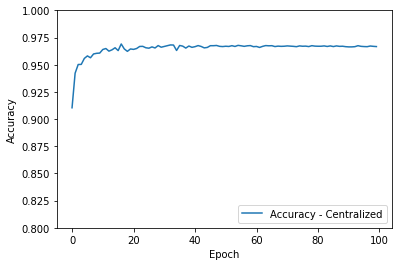

In [8]:
plt.plot(hist.history['val_sparse_categorical_accuracy'], label='Accuracy - Centralized')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.8,1])
plt.legend(loc='lower right')

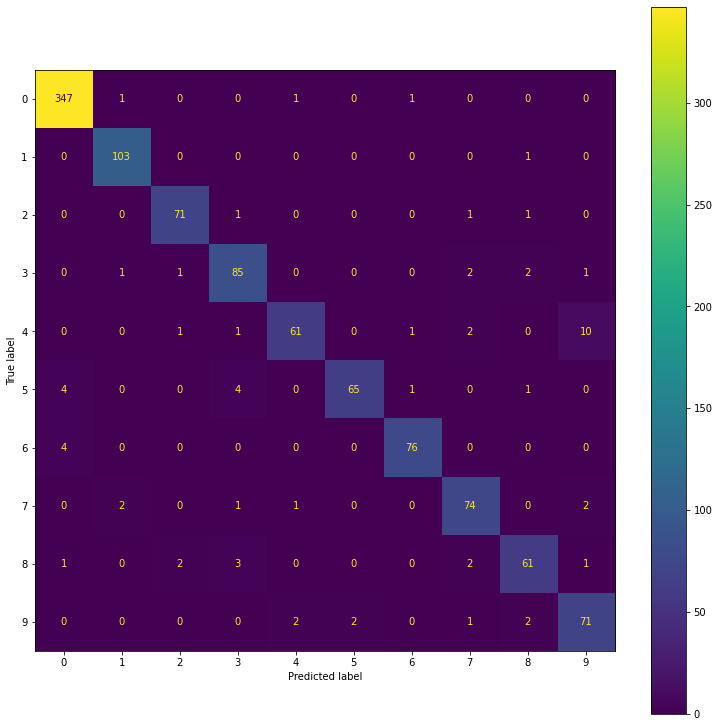

In [49]:
cnumber = 0
c = server.clients
local_preds = c[cnumber].local_pred()
global_preds = c[cnumber].global_pred()
combined_preds = []
        
local_dict = metrics.classification_report(c[cnumber].dataset.testing_labels, [np.argmax(p) for p in local_preds], output_dict=True)
global_dict = metrics.classification_report(c[cnumber].dataset.testing_labels, [np.argmax(p) for p in global_preds], output_dict=True)
        
for i in range(len(local_preds)):
    if np.argmax(local_preds[i]) == np.argmax(global_preds[i]):
        combined_preds.append(local_preds[i])
    elif local_dict[str(np.argmax(local_preds[i]))]['f1-score'] > global_dict[str(np.argmax(global_preds[i]))]['f1-score']:
        combined_preds.append(local_preds[i])
    else:
        combined_preds.append(global_preds[i])

#self.ensemble_results.append(metrics.classification_report(self.dataset.testing_labels, combined_preds, output_dict=True, digits=4))
#res = self.calculate_metrics(combined_preds)



cm = metrics.confusion_matrix(c[cnumber].dataset.testing_labels, tf.argmax(combined_preds, axis=1))
cmd = metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3,4,5,6,7,8,9])
fig, ax = plt.subplots(figsize=(13,13))
cmd.plot(ax=ax)

In [83]:
cnumber = 2
local_preds = server1.clients[cnumber].local_pred()
global_preds = server1.clients[cnumber].global_pred()
combined_preds = []
        
local_dict = metrics.classification_report(server1.clients[cnumber].dataset.testing_labels, [np.argmax(p) for p in local_preds], output_dict=True)
global_dict = metrics.classification_report(server1.clients[cnumber].dataset.testing_labels, [np.argmax(p) for p in global_preds], output_dict=True)
        
for i in range(len(local_preds)):
    if np.argmax(local_preds[i]) == np.argmax(global_preds[i]):
        combined_preds.append(local_preds[i])
    elif local_dict[str(np.argmax(local_preds[i]))]['f1-score'] > global_dict[str(np.argmax(global_preds[i]))]['f1-score']:
        combined_preds.append(local_preds[i])
    elif local_dict[str(np.argmax(local_preds[i]))]['f1-score'] < global_dict[str(np.argmax(global_preds[i]))]['f1-score']:
        combined_preds.append(global_preds[i])
    else:
        combined_preds.append(global_preds[i])
        
        


In [50]:
print(metrics.classification_report(c[cnumber].dataset.testing_labels, tf.argmax(combined_preds, axis=1)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       350
           1       0.96      0.99      0.98       104
           2       0.95      0.96      0.95        74
           3       0.89      0.92      0.91        92
           4       0.94      0.80      0.87        76
           5       0.97      0.87      0.92        75
           6       0.96      0.95      0.96        80
           7       0.90      0.93      0.91        80
           8       0.90      0.87      0.88        70
           9       0.84      0.91      0.87        78

    accuracy                           0.94      1079
   macro avg       0.93      0.92      0.92      1079
weighted avg       0.94      0.94      0.94      1079



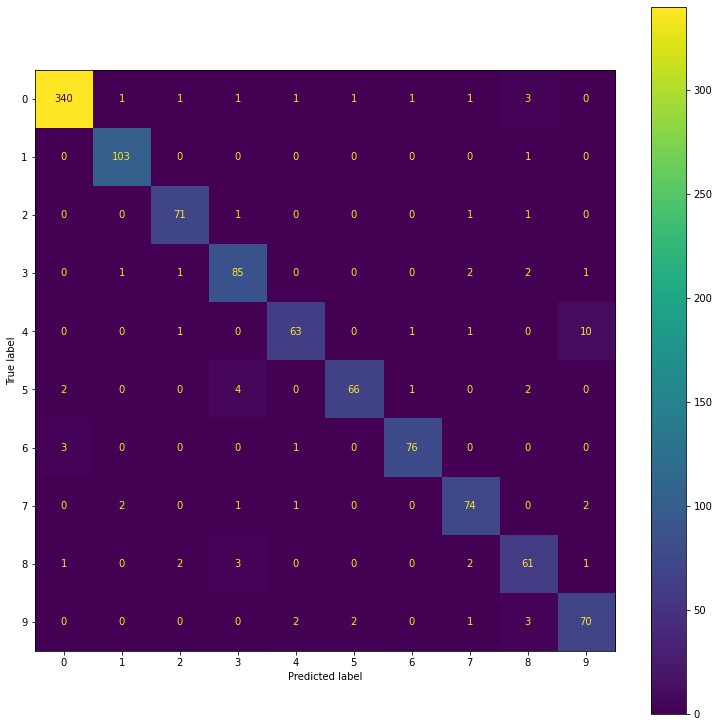

In [47]:
size = len(server.clients[0].local_weights)
avg_weights = []
local_scaling_factor  = server.clients[0].get_sample_amount() / server.get_total_samples()
global_scaling_factor = 1 - local_scaling_factor
for i in range(size):
    avg_weights.append(server.clients[0].local_weights[i] * local_scaling_factor + server.clients[0].global_weights[i] * global_scaling_factor)

server.clients[0].model.set_weights(avg_weights)
prediction = server.clients[0].model(server.clients[0].dataset.testing_data, training=False)


cm = metrics.confusion_matrix(server.clients[0].dataset.testing_labels, tf.argmax(prediction, axis=1))
cmd = metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3,4,5,6,7,8,9])
fig, ax = plt.subplots(figsize=(13,13))
cmd.plot(ax=ax)